# Model Population Notebook

This notebook covers:
- The creation of uniform population input files
- An example of how to run a simulation, summarise the results, and plot them
- Example results demonstrating the different simulations that can be run and some simple comparisons.

We begin by importing the necessary modules.

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt

import pyEpiabm as pe

For this example, we will create an 8x8 grid, consisting of 64 cells, and uniformly distribute a population of 10,000 people across the grid. 
Since the number of individuals in each cell is rounded down by the use of the `int()` function, the total popultion will be lower than the intended value of 10,000. We therefore add an extra individual to the last microcells listed in the population configuration file in order to make up the total population size to 10,000. The number of microcells to which an extra person is added is therefore calculated as the difference between the intended population size of 10,000 and the current population size, given by `sum(suseptible)`.

In [3]:
cell_grid = 8 # dimensions of grid

cell = []
microcell = []
location_x = []
location_y = []
household = []
place = []
susceptible = []

total_population = 10000
microcell_per_cell_grid = 3 # arranges microcells in a 3x3 grid within each cell

total_cells = cell_grid * cell_grid
microcells_per_cell = microcell_per_cell_grid * microcell_per_cell_grid
total_microcells = total_cells * microcells_per_cell

population_per_cell = total_population / total_cells
population_per_microcell = population_per_cell / microcells_per_cell

household_per_microcell = population_per_microcell / 5
place_per_microcell = 5

household = [int(household_per_microcell)] * total_microcells
place = [place_per_microcell] * total_microcells
susceptible = [int(population_per_microcell)] * total_microcells

for i in range(total_cells):
    for j in range(microcells_per_cell):
        cell.append(i)
        microcell.append(j)

for i in range(cell_grid):
    for j in range(cell_grid):
        for k in range(microcell_per_cell_grid):
            for l in range(microcell_per_cell_grid):
                x = i
                y = j
                location_x.append(x)
                location_y.append(y)

# Make up the population size to 10,000
new_susceptible = susceptible[:-(total_population - sum(susceptible))]+[x + 1 for x in susceptible[-(total_population - sum(susceptible)):]]

df = pd.DataFrame(list(zip(cell, microcell, location_x, location_y, household, place, new_susceptible)),
               columns =['cell', 'microcell', 'location_x', 'location_y', 'household_number', 'place_number', 'Susceptible'])

df.to_csv("input_8x8.csv", index = False)  

We run five repeat simulations for the example population, saving the output of each for subseqent processing.
All simulations begin with 10 infected individuals and are run for 150 days.

In [6]:
# load in parameter file
pe.Parameters.set_file(os.path.join(os.path.abspath(''),
                                    "noInt_params.json"))

# load in the population configuration file
file_loc = "input_8x8.csv"
output_file = "output_8x8_rep{}.csv"

number_repetitions = 5

# we run the simulation for 5 repetitions by changing the seed 
for i in range(number_repetitions):
    print("Set seed to:", i)
    set_seed = i
    population = pe.routine.FilePopulationFactory.make_pop(file_loc,
                                                        random_seed=i)

    # sim_ and file_params give details for the running of the simulations
    # and where output should be written to.
    sim_params = {"simulation_start_time": 0, "simulation_end_time":150,
                "initial_infected_number": 10,
                "initial_infect_cell": True,
                "simulation_seed": i}

    # we save each repetition to a separate dataframe
    file_params = {"output_file": output_file.format(i),
                "output_dir": os.path.join(os.path.abspath(''),
                                            "simulation_outputs"),
                "spatial_output": True,
                "age_stratified": False}

    # Create a simulation object, configure it with the parameters given,
    # then run the simulation.
    sim = pe.routine.Simulation()
    sim.configure(
        population,
        [pe.sweep.InitialHouseholdSweep(),
            pe.sweep.InitialInfectedSweep(),
            pe.sweep.InitialisePlaceSweep()],
        [
            pe.sweep.UpdatePlaceSweep(),
            pe.sweep.HouseholdSweep(),
            pe.sweep.PlaceSweep(),
            pe.sweep.SpatialSweep(),
            pe.sweep.QueueSweep(),
            pe.sweep.HostProgressionSweep(),
        ],
        sim_params,
        file_params,
    )
    sim.run_sweeps()

    # Need to close the writer object at the end of each simulation.
    del (sim.writer)
    del (sim)


Set seed to: 0


100%|██████████| 150/150 [00:48<00:00,  3.08it/s]


Set seed to: 1


100%|██████████| 150/150 [00:44<00:00,  3.34it/s]


Set seed to: 2


100%|██████████| 150/150 [00:52<00:00,  2.84it/s]


Set seed to: 3


100%|██████████| 150/150 [00:48<00:00,  3.10it/s]


Set seed to: 4


100%|██████████| 150/150 [00:47<00:00,  3.19it/s]


We then calculate the mean and standard deviation across the repetitions.

In [7]:
combined_df = pd.DataFrame()
summary_df = pd.DataFrame()

count = 0
for i in range(number_repetitions):
    file = output_file.format(i)
    filename = os.path.join(os.path.abspath(''), "simulation_outputs",
                            file)
    SIRdf = pd.read_csv(filename)
    os.remove(filename)
    total = SIRdf[list(SIRdf.filter(regex='InfectionStatus.Infect'))]
    SIRdf["Infected"] = total.sum(axis=1)
    SIRdf = SIRdf.groupby(["time"]).agg(
                                    {"InfectionStatus.Susceptible": 'sum',
                                    "Infected": 'sum',
                                    "InfectionStatus.Recovered": 'sum',
                                    "InfectionStatus.Dead": 'sum'})
    SIRdf.rename(columns={"InfectionStatus.Susceptible": "Susceptible_{}".format(count),
                        "InfectionStatus.Recovered": "Recovered_{}".format(count),
                        "Infected": "Infected_{}".format(count)},
                inplace=True)
    combined_df["Susceptible_{}".format(count)] = SIRdf["Susceptible_{}".format(count)]
    combined_df["Recovered_{}".format(count)] = SIRdf["Recovered_{}".format(count)]
    combined_df["Infected_{}".format(count)] = SIRdf["Infected_{}".format(count)]
    count += 1

all_infections = combined_df[list(combined_df.filter(regex='Infected'))]
all_susceptible = combined_df[list((combined_df.filter(regex='Susceptible')))]
all_recovered = combined_df[list((combined_df.filter(regex='Recovered')))]

summary_df["av_infections"] = all_infections.mean(axis=1)
summary_df["sd_infections"] = all_infections.std(axis=1)
summary_df["av_susceptible"] = all_susceptible.mean(axis=1)
summary_df["sd_susceptible"] = all_susceptible.std(axis=1)
summary_df["av_recovered"] = all_recovered.mean(axis=1)
summary_df["sd_recovered"] = all_recovered.std(axis=1)



time_list = []
for i in range(len(summary_df["av_infections"])):
    time_list.append(i)

summary_df["time"] = time_list

Finally, we plot the infection curve along with the standard deviations.

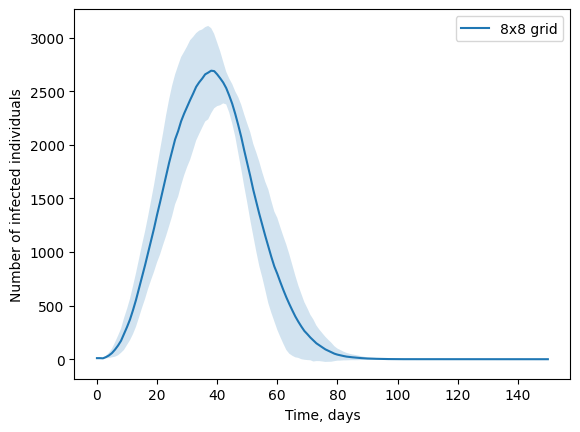

In [8]:
plt.figure()

plt.plot(summary_df['time'], summary_df['av_infections'], label=('8x8 grid'))
plt.legend()
plt.fill_between(summary_df['time'], 
                 summary_df['av_infections'] - summary_df['sd_infections'], 
                 summary_df['av_infections'] + summary_df['sd_infections'], 
                 alpha=0.2)
plt.xlabel('Time, days')
plt.ylabel('Number of infected individuals')
plt.show()

We can then compare the infection curves for different grid sizes ranging from 15x15 to 4x4.

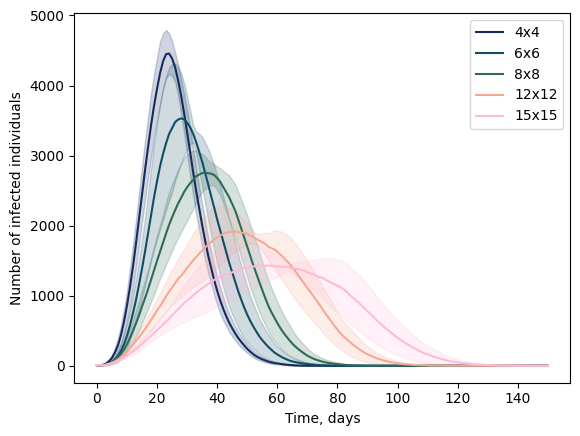

In [9]:
file_name = "simulation_outputs/combined_summary.csv"

combined_df = pd.read_csv(file_name)
plt.figure()

grid_list = [4, 6, 8, 12, 15]
colour_list = ['#142C5F', '#124E63', '#2E6A57', '#F6A895', '#FFBAD7']

count = 0
for element in grid_list:

    plt.plot(combined_df['time'], combined_df['av_infections_{}'.format(element)], color = colour_list[count], label=(str(element)+'x'+str(element)))
    plt.legend()
    plt.fill_between(combined_df['time'], 
                    combined_df['av_infections_{}'.format(element)] - combined_df['sd_infections_{}'.format(element)], 
                    combined_df['av_infections_{}'.format(element)] + combined_df['sd_infections_{}'.format(element)], 
                    color=colour_list[count], alpha=0.2)

    count += 1
plt.xlabel('Time, days')
plt.ylabel('Number of infected individuals')
plt.show()